In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import os
import seaborn as sns

from tabulate import tabulate
from scipy.stats import pearsonr, spearmanr, zscore

pd.set_option("display.width", 80)
pd.set_option("display.max_colwidth", None)

In [3]:
# 1. load all data files and pair them as a corpus
data_files = os.listdir("data")
reward_df_files = sorted(
    [f for f in data_files if "scoredreward_humanassistant_includeprompt" in f]
)
nll_df_files = sorted([f for f in data_files if "scorednll" in f and "condition" in f])
correction_files = sorted([f for f in data_files if "scoredcorrectionnll" in f])

triplet_files = [
    (r, n, c) for r, n, c in zip(reward_df_files, nll_df_files, correction_files)
]
assert len(reward_df_files) == len(nll_df_files) == len(correction_files)

print(triplet_files)

[('ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv', 'ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.0_humanassistant_scorednll_humanassistant_includeprompt_conditioned.csv', 'ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.0_humanassistant_scoredcorrectionnll_ancestral_1.0_humanassistant_includeprompt_conditioned.csv'), ('ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.5_humanassistant_scoredreward_humanassistant_includeprompt.csv', 'ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.5_humanassistant_scorednll_humanassistant_includeprompt_conditioned.csv', 'ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.5_humanassistant_scoredcorrectionnll_ancestral_1.5_humanassistant_includep

In [4]:
# 2. set parameters
num_corpuses = 1000
num_samples_per_corpus = 1000
metropolis_steps = 50_000

colours = [
    "r",
    "b",
    "g",
    "y",
    "m",
    "c",
    "lightcoral",
    "lightblue",
    "lightgreen",
    "lightyellow",
    "lightpink",
    "lightcyan",
    "gray",
]
names = [
    "k50_t1.0",
    "k50_t1.5",
    "k50_t2.0",
    "p090_t1.0",
    "p090_t1.5",
    "p090_t2.0",
    "p095_t1.0",
    "p095_t1.5",
    "p095_t2.0",
    "anc_t1.0",
]

In [5]:
reward_df_file, nll_df_file, correction_df_file = triplet_files[0]
print(f"\n\nAnalyzing {reward_df_file} and {nll_df_file}:")
# 3.1 load and merge
reward_df = pd.read_csv(f"data/{reward_df_file}")
nll_df = pd.read_csv(f"data/{nll_df_file}")
correction_df = pd.read_csv(f"data/{correction_df_file}")
df = reward_df.merge(nll_df, on=["prompt", "generated_text"]).merge(
    correction_df, on=["prompt", "generated_text"]
)



Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.0_humanassistant_scorednll_humanassistant_includeprompt_conditioned.csv:


In [11]:
# metropolis hastings on df
samples = df.sample(n=metropolis_steps + 1, replace=True, random_state=0)
acceptance_thresholds = np.random.uniform(0.0, 1.0, size=metropolis_steps)
acceptances = dict()
acceptance_count = 0
prev = samples.iloc[0]
for step in range(1, metropolis_steps + 1):
    sample = samples.iloc[step]
    acceptance = (
        min(
            1.0,
            (
                np.exp(
                    -sample["original_negative_log_probability"]
                    + prev["original_negative_log_probability"]
                ).item()
            ),
        )
        > acceptance_thresholds[step - 1],
    )

    if acceptance:
        acceptance_count += 1
        prev = sample
    acceptances[(sample["prompt"], sample["generated_text"])] = acceptance
acceptance_rate = np.mean(list(acceptances.values()))
print(f"Algorithm acceptance rate: {acceptance_count/metropolis_steps}")
print(f"Acceptance rate: {acceptance_rate}")
df["acceptance"] = df.apply(
    lambda row: acceptances.get((row["prompt"], row["generated_text"]), False), axis=1
)

Algorithm acceptance rate: 1.0
Acceptance rate: 0.42820380854348944


In [34]:
df[df["acceptance"] == True].drop_duplicates().describe()

,score,negative_log_probability,original_negative_log_probability,samplingbiased_negative_log_probability
count,123.000000,123.000000,123.000000,123.000000
mean,6.040431,11.018618,0.419262,0.417080
std,0.822652,1.327080,0.760614,0.758542
min,3.466897,1.679091,0.036111,0.036042
25%,5.531446,10.374802,0.115868,0.114884
50%,6.065457,10.997766,0.192392,0.192048
75%,6.560681,11.632135,0.391365,0.390616
max,8.222457,14.371186,4.972819,4.971948




Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.0_humanassistant_scorednll_humanassistant_includeprompt_conditioned.csv:
Length: 1943
+----+------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------+---------------------------------------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_3759445/2603870826.py:66: RuntimeWarning: overflow encountered in exp
  np.exp(


Algorithm acceptance rate: 1.0
Acceptance rate: 0.505
===== Sample level statistics =====
Spearman: SignificanceResult(statistic=0.3531874842968711, pvalue=7.876312375696726e-60)
Pearson: PearsonRResult(statistic=0.35314174518579317, pvalue=8.173211785068817e-60)
===== Corpus level statistics =====
Spearman: SignificanceResult(statistic=0.31284897684897683, pvalue=3.812704931933661e-24)
Pearson: PearsonRResult(statistic=0.33370238909397193, pvalue=1.951519042983932e-27)
===== Corrected corpus level statistics =====
Spearman: SignificanceResult(statistic=-0.9999632649631547, pvalue=0.0)
Pearson: PearsonRResult(statistic=-0.9999849683858617, pvalue=0.0)


Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_p090_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_p090_t1.0_humanassistant_scorednll_humanassistant_includeprompt_conditioned.csv:
Length: 19

/tmp/ipykernel_3759445/2603870826.py:66: RuntimeWarning: overflow encountered in exp
  np.exp(


Algorithm acceptance rate: 1.0
Acceptance rate: 0.5035035035035035
===== Sample level statistics =====
Spearman: SignificanceResult(statistic=0.29337381965097925, pvalue=5.943850264237789e-41)
Pearson: PearsonRResult(statistic=0.26723974624011143, pvalue=5.0953203056457575e-34)
===== Corpus level statistics =====
Spearman: SignificanceResult(statistic=0.2874857394857395, pvalue=1.7555535468592114e-20)
Pearson: PearsonRResult(statistic=0.2978193155557955, pvalue=6.249610962525439e-22)
===== Corrected corpus level statistics =====
Spearman: SignificanceResult(statistic=-0.999212314957127, pvalue=0.0)
Pearson: PearsonRResult(statistic=-1.0, pvalue=0.0)


Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_p095_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_p095_t1.0_humanassistant_scorednll_humanassistant_includeprompt_conditioned.csv:
Length: 1921

/tmp/ipykernel_3759445/2603870826.py:66: RuntimeWarning: overflow encountered in exp
  np.exp(


Algorithm acceptance rate: 1.0
Acceptance rate: 0.5072608913370055
===== Sample level statistics =====
Spearman: SignificanceResult(statistic=0.3166905087511448, pvalue=9.231131061010766e-48)
Pearson: PearsonRResult(statistic=0.3011999128172637, pvalue=3.725116781351328e-43)
===== Corpus level statistics =====
Spearman: SignificanceResult(statistic=0.32790990390990393, pvalue=1.6999464164427114e-26)
Pearson: PearsonRResult(statistic=0.3377491885704848, pvalue=4.183716937378358e-28)
===== Corrected corpus level statistics =====
Spearman: SignificanceResult(statistic=-0.9995109641549222, pvalue=0.0)
Pearson: PearsonRResult(statistic=-1.0, pvalue=0.0)
===== Total corpus level statistics =====
Spearman: SignificanceResult(statistic=0.2666609709154131, pvalue=4.009952219720816e-286)
Pearson: PearsonRResult(statistic=0.17761682418416083, pvalue=1.6419191603105531e-125)
===== Total corpus mean statistics =====
Spearman: SignificanceResult(statistic=-0.9522098226814062, pvalue=0.0)
Pearson: Pe

/tmp/ipykernel_3759445/2603870826.py:275: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[3].set_xticklabels(acceptance_x, rotation=45)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


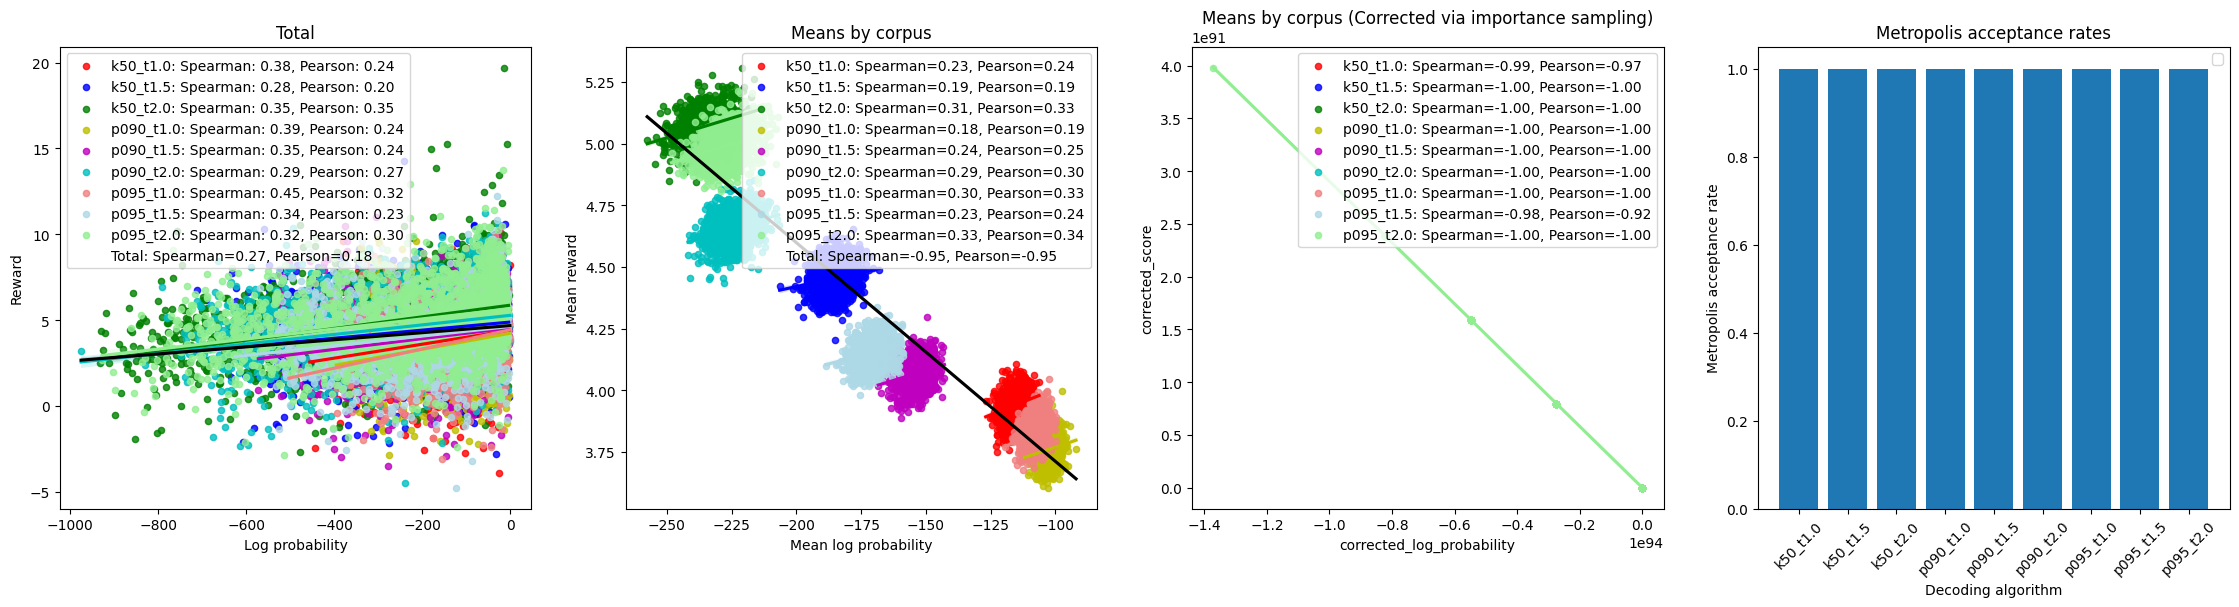

In [18]:
# 3. analysis on each corpus
# 3.0 a single output figure
fig, axs = plt.subplots(1, 4, figsize=(28, 6))
total_mean_corpuses = None
total_corpus = None
total_mean_corrected_corpuses = None
acceptance_rates = dict()
for idx, (reward_df_file, nll_df_file, correction_df_file) in enumerate(triplet_files):
    print(f"\n\nAnalyzing {reward_df_file} and {nll_df_file}:")
    # 3.1 load and merge
    reward_df = pd.read_csv(f"data/{reward_df_file}")
    nll_df = pd.read_csv(f"data/{nll_df_file}")
    correction_df = pd.read_csv(f"data/{correction_df_file}")
    df = reward_df.merge(nll_df, on=["prompt", "generated_text"]).merge(
        correction_df, on=["prompt", "generated_text"]
    )

    # 3.1.1 get log probability
    df["log_probability"] = -df["negative_log_probability"]

    # 3.1.2 filter duplicates, empty strings, invalid probabilities
    df = df[
        df.apply(lambda row: len(row["generated_text"]) > 0, axis=1)
    ].drop_duplicates()
    df = df[
        df["log_probability"].apply(
            lambda x: False if (np.isinf(x) or np.isnan(x)) else True
        )
    ]
    print(f"Length: {len(df)}")
    print(tabulate(df.head(), headers="keys", tablefmt="psql"))
    print(
        tabulate(
            df[["score", "log_probability"]].describe(), headers="keys", tablefmt="psql"
        )
    )

    # 3.1.3 compute correction ratio
    df["correction_ratio"] = df.apply(
        lambda row: np.exp(
            -row["original_negative_log_probability"]
            + row["samplingbiased_negative_log_probability"]
        ),
        axis=1,
    )
    df["corrected_score"] = df.apply(
        lambda row: row["score"] * row["correction_ratio"], axis=1
    )
    df["corrected_log_probability"] = df.apply(
        lambda row: row["log_probability"] * row["correction_ratio"],
        axis=1,
    )

    # 3.1.4 metropolis algorithm
    samples = df.sample(n=metropolis_steps + 1, replace=True, random_state=0)
    acceptance_thresholds = np.random.uniform(0.0, 1.0, size=metropolis_steps)
    acceptances = dict()
    acceptance_count = 0
    prev = samples.iloc[0]
    for step in range(1, metropolis_steps + 1):
        sample = samples.iloc[step]
        acceptance = (
            min(
                1.0,
                (
                    np.exp(
                        -sample["original_negative_log_probability"]
                        + prev["original_negative_log_probability"]
                    ).item()
                ),
            )
            > acceptance_thresholds[step - 1],
        )
        if acceptance:
            acceptance_count += 1
            prev = sample
        acceptances[(sample["prompt"], sample["generated_text"])] = acceptance
    acceptance_rate = np.mean(list(acceptances.values()))
    algorithm_acceptance_rate = acceptance_count / metropolis_steps
    print(f"Algorithm acceptance rate: {algorithm_acceptance_rate}")
    print(f"Acceptance rate: {acceptance_rate}")
    df["acceptance"] = df.apply(
        lambda row: acceptances.get((row["prompt"], row["generated_text"]), False),
        axis=1,
    )
    # df = df[df["acceptance"] == True].drop_duplicates()

    # 3.1.4.1 plot acceptance rate
    acceptance_rates[names[idx]] = algorithm_acceptance_rate

    # 3.2 Sample level
    print("===== Sample level statistics =====")
    # 3.2.1 Scatter
    spearman = spearmanr(df["score"], df["log_probability"])
    pearson = pearsonr(df["score"], df["log_probability"])
    print(f"Spearman: {spearman}")
    print(f"Pearson: {pearson}")
    df.plot.scatter(
        y="score",
        x="log_probability",
        title="Samples",
        ax=axs[0],
        c=colours[idx],
        alpha=0.8,
        label=f"{names[idx]}: Spearman: {spearman[0]:.2f}, Pearson: {pearson[0]:.2f}",
    )
    # 3.2.2 best fit line
    sns.regplot(
        y="score",
        x="log_probability",
        data=df,
        ax=axs[0],
        scatter=False,
        color=colours[idx],
    )
    if total_corpus is None:
        total_corpus = df
    else:
        total_corpus = pd.concat([total_corpus, df])

    # 3.3 Corpus level
    print("===== Corpus level statistics =====")
    # 3.3.1 Sample corpuses
    corpuses = {
        corpus_seed: df.sample(
            num_samples_per_corpus, random_state=corpus_seed, replace=True
        )
        for corpus_seed in range(num_corpuses)
    }
    mean_corpuses_df = pd.DataFrame.from_dict({
        corpus_seed: corpus[["score", "log_probability"]].mean(axis=0)
        for corpus_seed, corpus in corpuses.items()
    }).T
    spearman = spearmanr(mean_corpuses_df["score"], mean_corpuses_df["log_probability"])
    pearson = pearsonr(mean_corpuses_df["score"], mean_corpuses_df["log_probability"])
    print(f"Spearman: {spearman}")
    print(f"Pearson: {pearson}")
    mean_corpuses_df.plot.scatter(
        y="score",
        x="log_probability",
        title="Means by corpus",
        ax=axs[1],
        c=colours[idx],
        alpha=0.8,
        label=f"{names[idx]}: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}",
    )
    if total_mean_corpuses is None:
        total_mean_corpuses = mean_corpuses_df
    else:
        total_mean_corpuses = pd.concat([total_mean_corpuses, mean_corpuses_df])

    # 3.3.2 best fit line
    sns.regplot(
        y="score",
        x="log_probability",
        data=mean_corpuses_df,
        ax=axs[1],
        scatter=False,
        color=colours[idx],
    )

    # 3.4 corrected corpus level
    print("===== Corrected corpus level statistics =====")
    # 3.4.1 Sample corpuses
    corpuses = {
        corpus_seed: df.sample(
            num_samples_per_corpus, random_state=corpus_seed, replace=True
        )
        for corpus_seed in range(num_corpuses)
    }
    mean_corpuses_df = pd.DataFrame.from_dict({
        corpus_seed: corpus[["corrected_score", "corrected_log_probability"]].mean(
            axis=0
        )
        for corpus_seed, corpus in corpuses.items()
    }).T
    spearman = spearmanr(
        mean_corpuses_df["corrected_score"],
        mean_corpuses_df["corrected_log_probability"],
    )
    pearson = pearsonr(
        mean_corpuses_df["corrected_score"],
        mean_corpuses_df["corrected_log_probability"],
    )
    print(f"Spearman: {spearman}")
    print(f"Pearson: {pearson}")
    mean_corpuses_df.plot.scatter(
        y="corrected_score",
        x="corrected_log_probability",
        title="Means by corpus (Corrected via importance sampling)",
        ax=axs[2],
        c=colours[idx],
        alpha=0.8,
        label=f"{names[idx]}: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}",
    )
    if total_mean_corrected_corpuses is None:
        total_mean_corrected_corpuses = mean_corpuses_df
    else:
        total_mean_corrected_corpuses = pd.concat(
            [total_mean_corrected_corpuses, mean_corpuses_df]
        )

    # 3.4.2 best fit line
    sns.regplot(
        y="corrected_score",
        x="corrected_log_probability",
        data=mean_corpuses_df,
        ax=axs[2],
        scatter=False,
        color=colours[idx],
    )


# 4. Total corpus level statistics
print("===== Total corpus level statistics =====")
spearman = spearmanr(total_corpus["score"], total_corpus["log_probability"])
pearson = pearsonr(total_corpus["score"], total_corpus["log_probability"])
print(f"Spearman: {spearman}")
print(f"Pearson: {pearson}")
total_corpus.plot.scatter(
    y="score",
    x="log_probability",
    title="Total",
    alpha=0.0,
    label=f"Total: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}",
    ax=axs[0],
)
sns.regplot(
    y="score",
    x="log_probability",
    data=total_corpus,
    scatter=False,
    color="black",
    ax=axs[0],
)
axs[0].set_ylabel("Reward")
axs[0].set_xlabel("Log probability")


print("===== Total corpus mean statistics =====")
spearman = spearmanr(
    total_mean_corpuses["score"], total_mean_corpuses["log_probability"]
)
pearson = pearsonr(total_mean_corpuses["score"], total_mean_corpuses["log_probability"])
print(f"Spearman: {spearman}")
print(f"Pearson: {pearson}")
total_mean_corpuses.plot.scatter(
    y="score",
    x="log_probability",
    title="Means by corpus",
    alpha=0.0,
    label=f"Total: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}",
    ax=axs[1],
    ylabel="Mean score",
    xlabel="Mean log probability",
)

sns.regplot(
    y="score",
    x="log_probability",
    data=total_mean_corpuses,
    scatter=False,
    color="black",
    ax=axs[1],
)
axs[1].set_ylabel("Mean reward")
axs[1].set_xlabel("Mean log probability")

acceptance_x, acceptance_y = zip(*acceptance_rates.items())
axs[3].bar(acceptance_x, acceptance_y)
axs[3].set_xticklabels(acceptance_x, rotation=45)
axs[3].set_ylabel("Metropolis acceptance rate")
axs[3].set_xlabel("Decoding algorithm")
axs[3].set_title("Metropolis acceptance rates")

plt.legend()
plt.show()
plt.close()